# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features

%load_ext autoreload
%autoreload 2

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

In [5]:
# ax = plot_3D_setup(PC_data[0])
# cmap = cm.get_cmap('viridis')
# cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
# colors = np.asarray(cmap.colors)[cmap_idxs,:]

# for i, s in enumerate(scans):
#     s.plot(ax, color=colors[i])

Get correspondences

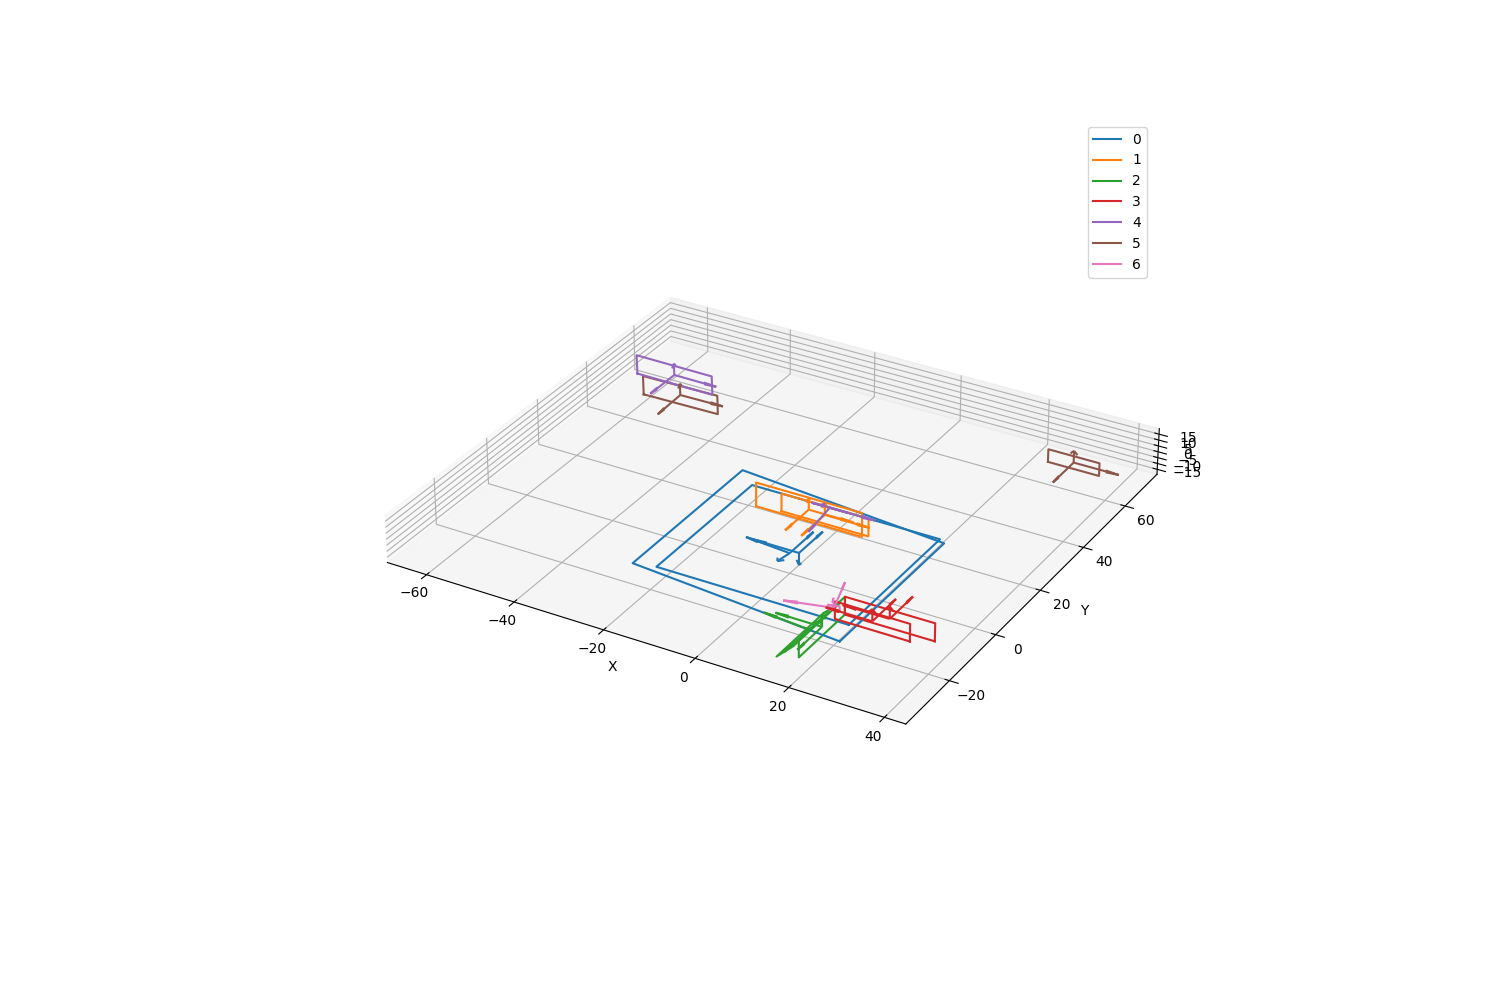

In [6]:
# Plot first 2 scans
ax = plot_3D_setup(PC_data[0])
for i, scan in enumerate(scans[0:2]):
    scan.plot(ax, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax, num_colors)

In [52]:
# Extract normals and distances
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[0], scans[1])

Test Gauss-Newton registration

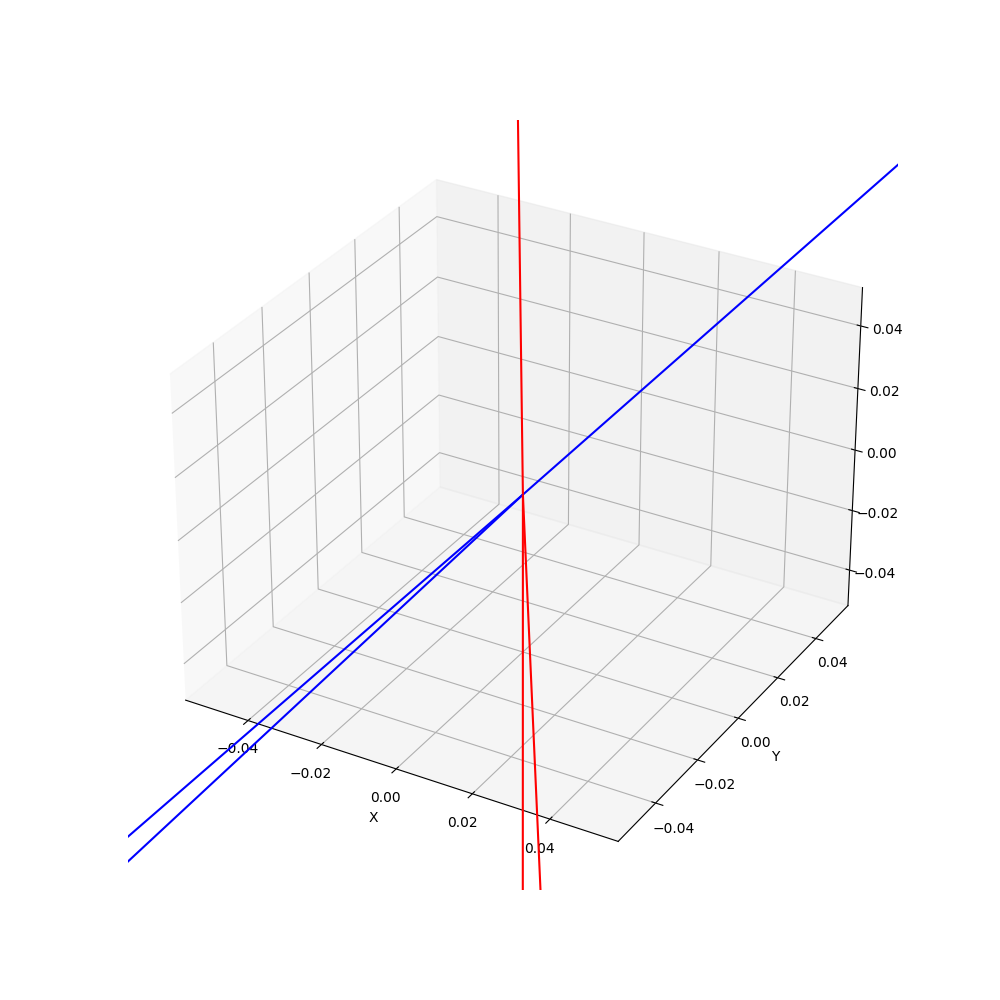

In [53]:
from planeslam.registration import transform_normals

ax = plot_3D_setup(figsize=(10,10))
for i in range(int(len(n_s)/3)):
    n = n_s[3*i:3*(i+1)]
    ax.quiver(0, 0, 0, n[0], n[1], n[2], color='b')

t = np.array([0, 0, 0])[:,None]
u = np.array([0, 0, 1])[:,None]
theta = np.radians(30)
q = np.vstack((t, theta*u))

n_s_T = transform_normals(n_s, q)

for i in range(int(len(n_s)/3)):
    n = n_s_T[3*i:3*(i+1)]
    ax.quiver(0, 0, 0, n[0], n[1], n[2], color='r')

In [54]:
from planeslam.registration import residual, jacobian

# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-3

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    q = q + np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

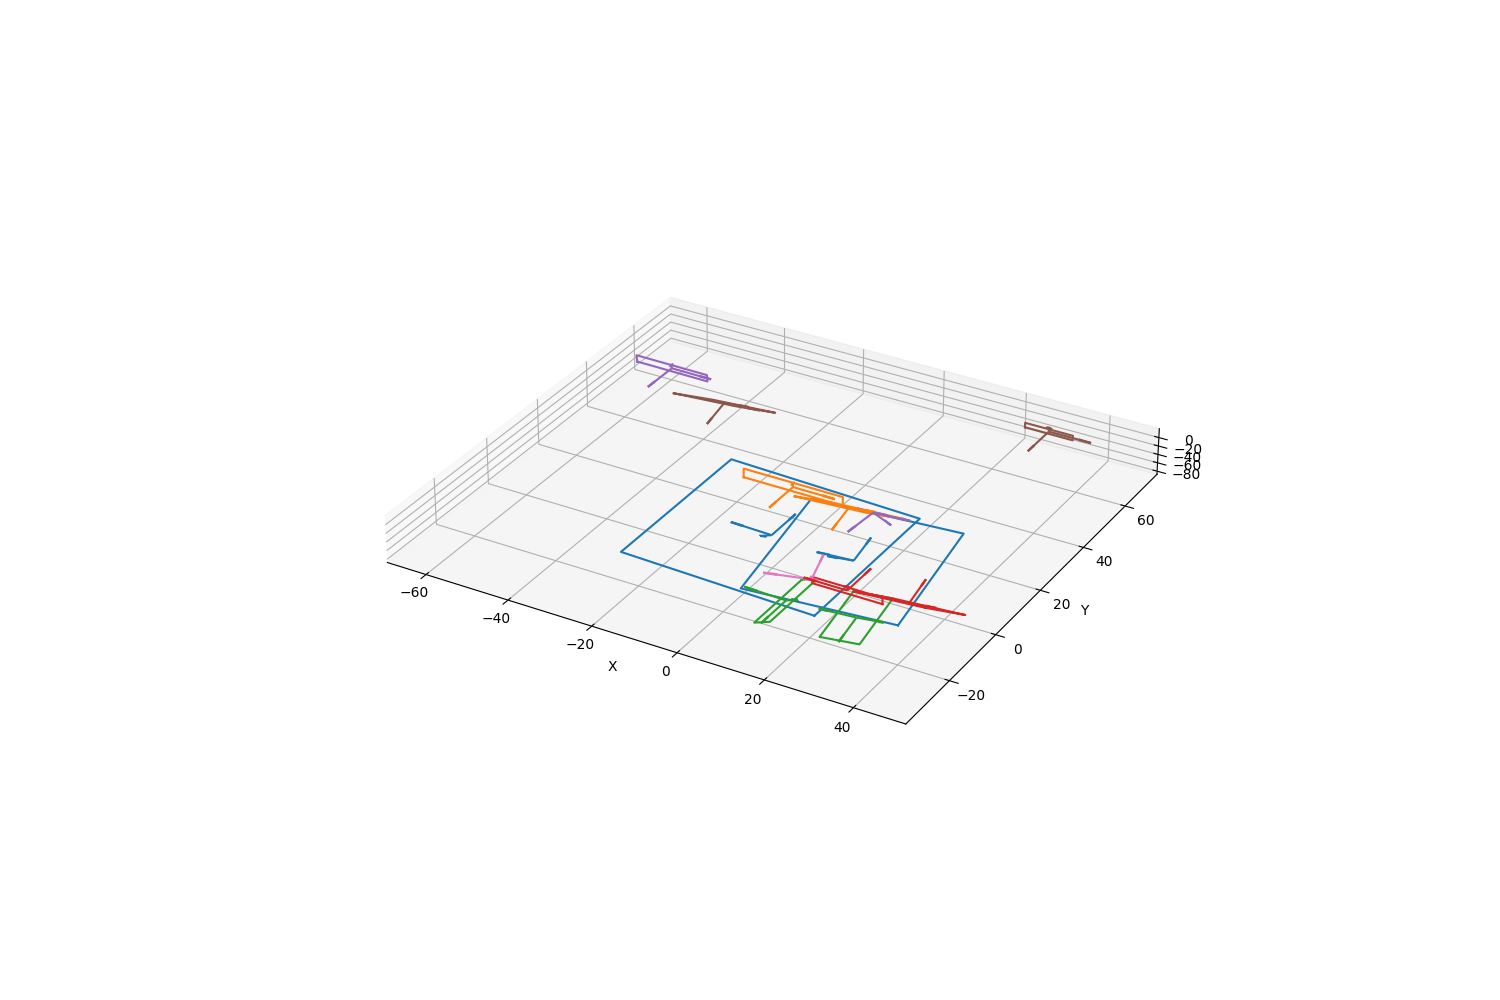

In [61]:
# Extract R and t from q
t_est = q[:3]
R_est = expmap(q[3:].flatten())

source_transformed = scans[0]
source_transformed.transform(R_est, t_est.flatten())
target = scans[1]

ax = plot_3D_setup(PC_data[0])

source_transformed.plot(ax, show_normals=True)
target.plot(ax, show_normals=True)


Test with single plane

In [40]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
import copy

V = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
P = BoundedPlane(V)

# Ground-truth transformation
t = np.array([0, -2, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/4
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

In [41]:
# P is source, Q is target
Q = copy.copy(P)
Q.transform(R, t.flatten())

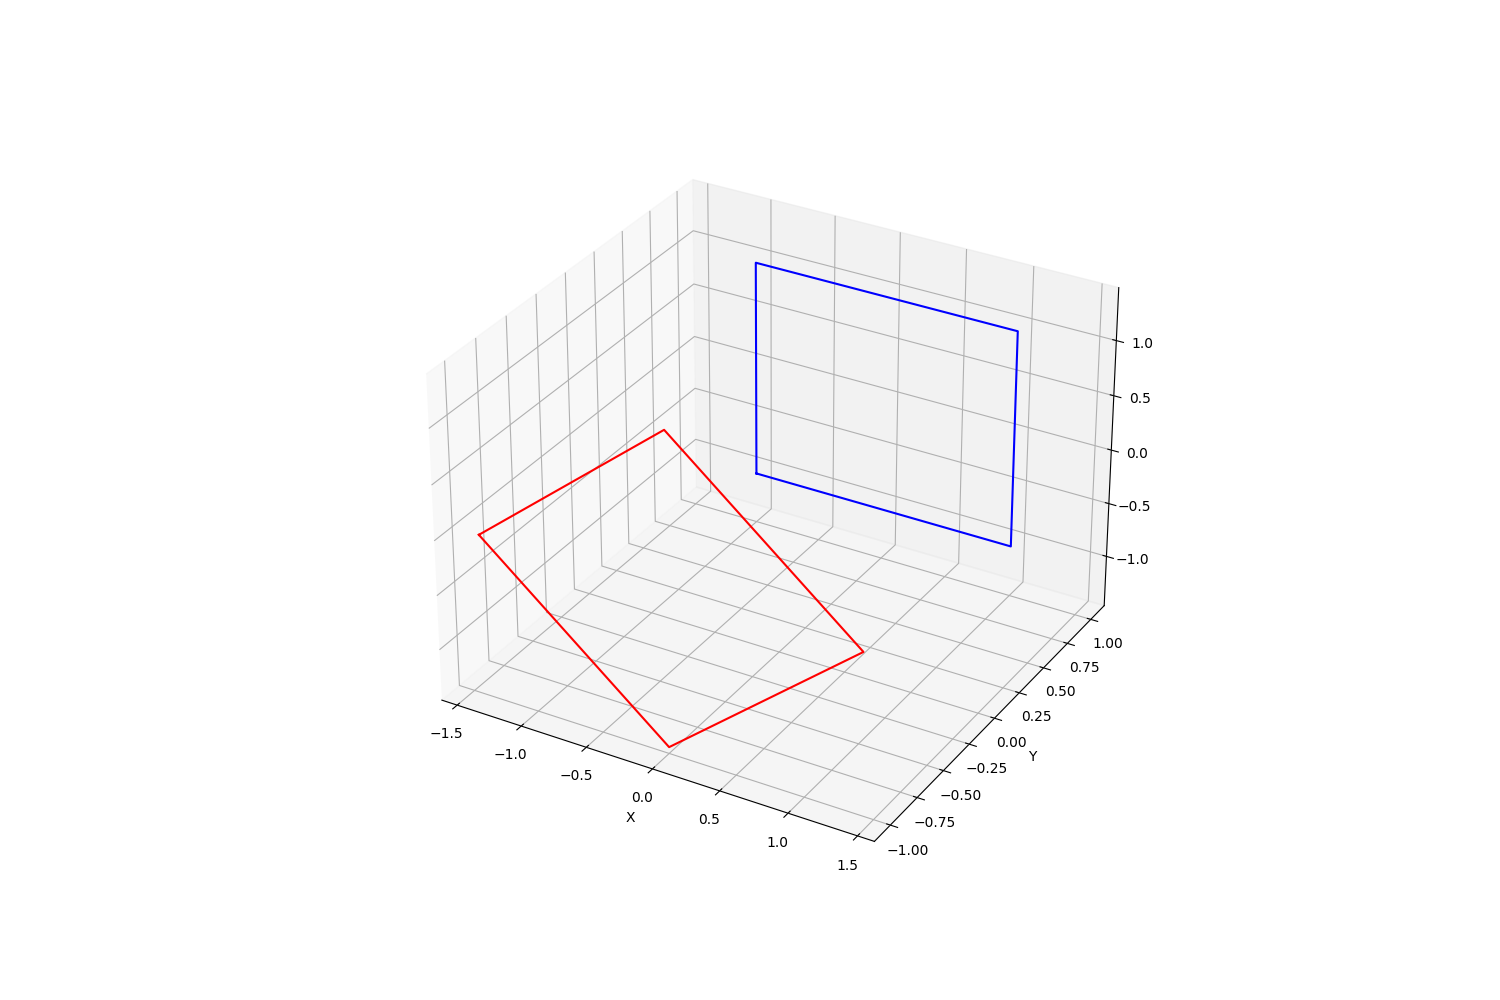

In [42]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [43]:
n_s = P.normal 
d_s = np.dot(P.normal.flatten(), P.center)
n_t = Q.normal 
d_t = np.dot(Q.normal.flatten(), Q.center)

In [44]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-3

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    q = q + np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

In [49]:
# Extract R and t from q
t_est = q[:3]
R_est = expmap(q[3:].flatten())

# Apply transformation to source
P_T = copy.copy(P)
P_T.transform(R_est, t_est.flatten())

In [50]:
t_est

array([[ 0.        ],
       [-2.        ],
       [-0.29870888]])

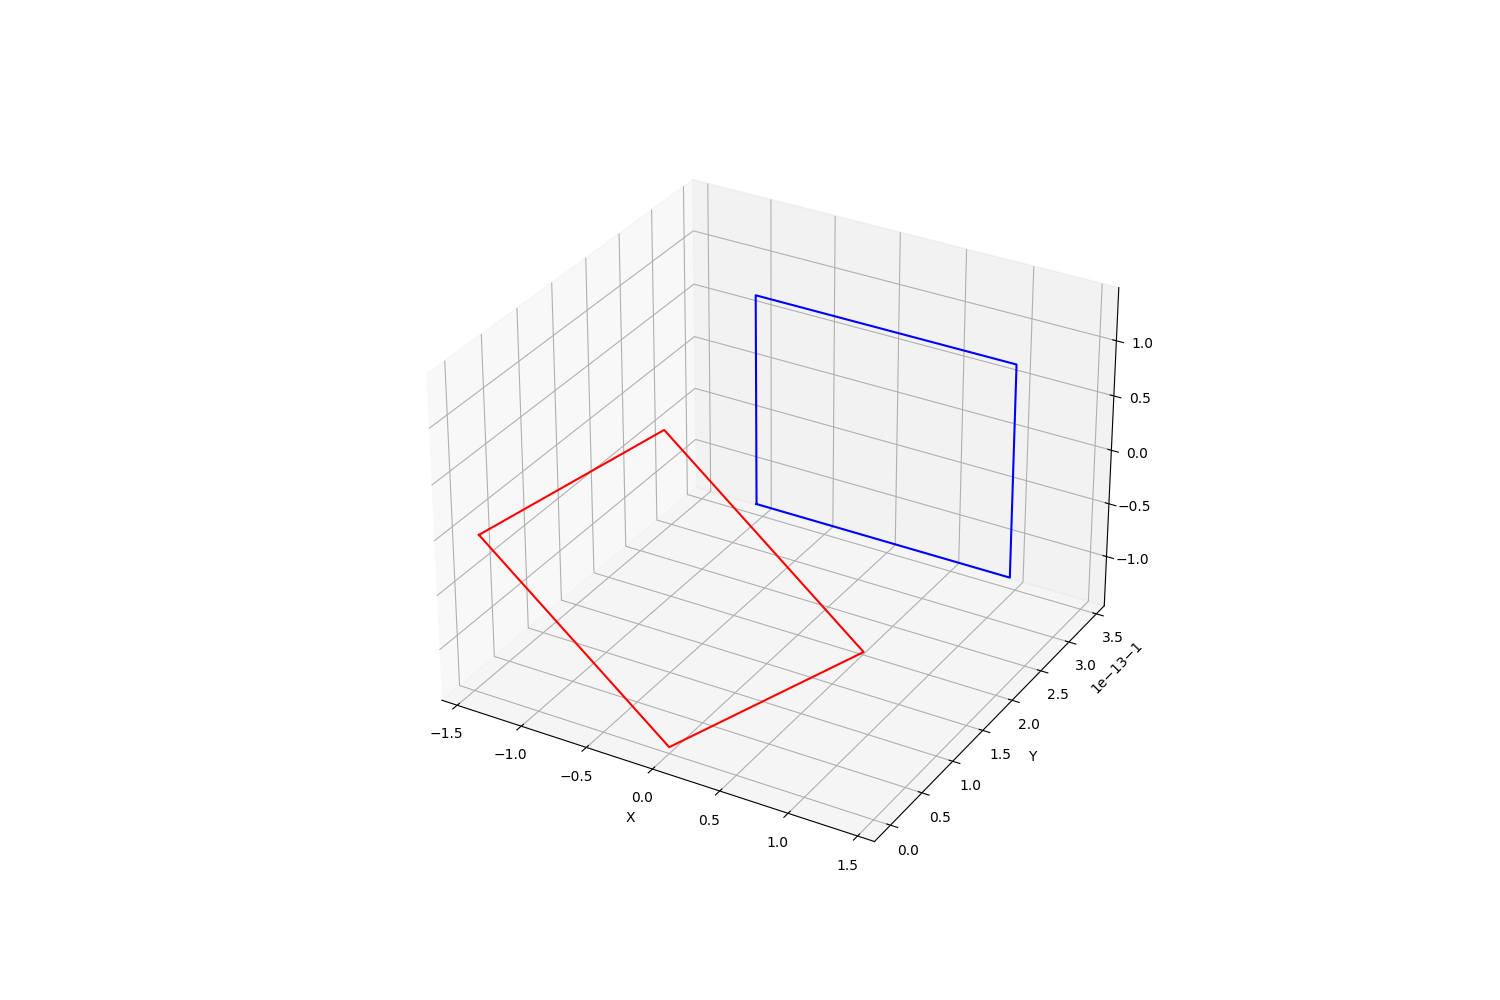

In [51]:
ax = plot_3D_setup()
P_T.plot(ax, color='b')
Q.plot(ax, color='r')